<a href="https://colab.research.google.com/github/AyozeGS/IABD/blob/main/7RO/T11_2/7RO_Python_To_TensorFlow_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ayoze Gil Sosa




## Flowers

Este cuaderno consiste en la clasificación de imágenes flores usando redes neuronales convolucionales (CNN) con la finalidad de extraer el modelo para ser probado en una aplicación web externa.

Las imágenes a usar para el entrenamiento y testeo de la mismas se han descargado originalmente de la paltaforma Kaggle.

Dataset Kaggle:
https://www.kaggle.com/datasets/imsparsh/flowers-dataset/

Sin embargo, para realizar esta actividad se cargan directamente desde un repositorio de Github

Dataset Github: https://github.com/AyozeGS/IABD/raw/main/7RO/T10_2/data/train.rar
https://github.com/AyozeGS/IABD/raw/main/7RO/T10_2/data/test.rar


## Importanción de librerías

In [1]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 1.6 MB/s eta 0:00:00


In [2]:
import os
import patoolib
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

import keras

## Carga de los datos

En primer lugar se descarga el fichero zip y se extrae en la ruta indicada.

In [4]:
# Rutas
zip_path = '/content/train.rar'
extraction_path = '/content/'

# Bajamos los datos del Github
keras.utils.get_file(fname=zip_path,
                     origin="https://github.com/AyozeGS/IABD/raw/main/7RO/T11_2/data/train.rar")

patoolib.extract_archive(zip_path, outdir=extraction_path, verbosity=-1)

print(f'Archivos extraídos en {extraction_path}')

164259766/164259766 [==============================] - 1s 0us/step
Archivos extraídos en /content/


Se comprueban la cantidad de imágenes que tenemos de cada pieza y se realiza un mapeo de las categorías.

In [5]:
data_path = '/content/train/'

# Carga todos los CSV en la carpeta en un diccionario de listas de DataFrames
for root, dirs, files in os.walk(data_path):
  if len(files):
        dir = root.split('/')[-1]
        count = 0
        count2 = 0
        for file in files:
          if file.lower().endswith(('.jpg')):
            count += 1
        print(dir, '->', count, 'imágenes')

dandelion -> 646 imágenes
tulip -> 607 imágenes
daisy -> 501 imágenes
sunflower -> 495 imágenes
rose -> 497 imágenes


## Creación del dataset

Funciones que cargan las imágenes del directorio y utilizan la librería PIL para hacer un reescalado y adaptarlas todas al mismo tamaño.

In [6]:
# Función que carga una imagen RGB utilizando la librería PIL permitiendo pasa
"""
  Args:
      filename: ruta completa del fichero a leer
      width: anchura de las imágenes creadas. 64 píxeles por defecto
      height: altura de la imágenes creadas. 64 píxeles por defecto
      on_gray_scale: Indica si las imágenes cargadas serán en escala de grises (1 capa). False por defecto
  Returns:
      image, imagen cargadas con tamaño width x height
  """
def get_image(filename, height=None, width=None, on_gray_scale=False, transform_tech=None):

  image = Image.open(filename)

  image = image.convert('RGB')
  if on_gray_scale:
    image = ImageOps.grayscale(image)

  if height and width:
    image = image.resize((width, height))

  match transform_tech:
    case 'flip':
      image = ImageOps.flip(image)
    case 'invert':
      image = ImageOps.invert(image)
    case 'mirror':
      image = ImageOps.mirror(image)
    case _:
      pass

  return image

# Función que crea un set de imágenes y sus etiquetas a partir de los ficheros de un directorio.
"""
  Args:
      dirname: directorio completo del que leer los datos
      map_characters: variable de mapeo entre labels y personajes
      width: anchura de las imágenes creadas. 64 píxeles por defecto
      height: altura de la imágenes creadas. 64 píxeles por defecto
      verbose: si es True, muestra información de las imágenes cargadas
      on_gray_scale: Cargadas la imagen en escala de grises (1 capa). False por defecto
  Returns:
      X, array con todas las imágenes cargadas con tamaño width x height
      y: array con las labels de correspondientes a cada imagen
  """
def load_set(dirname, map_characters, height=None, width=None, verbose=True, on_gray_scale=False, transform_techs=[]):

  X = []
  y = []

  for label, category in map_characters.items():

    files = os.listdir(os.path.join(dirname, category))
    images = [file for file in files if file.lower().endswith(("jpg", 'png', 'jpeg', 'gif'))]
    transform_techs_list = ['flip', 'invert', 'mirror']
    valid_transform_techs = np.intersect1d(transform_techs, transform_techs_list)
    invalid_transform_techs = np.setdiff1d(transform_techs, transform_techs_list)

    if verbose:
      print("Halladas {} imágenes de {}".format(len(images), category))

    for image_name in images:

      filename = os.path.join(dirname, category, image_name)

      image = get_image(filename, height=height, width=width, on_gray_scale=on_gray_scale)
      X.append(np.array(image))
      y.append(label)

      for transform_tech in valid_transform_techs:
            image = get_image(filename, height=height, width=width, on_gray_scale=on_gray_scale, transform_tech=transform_tech)
            X.append(np.array(image))
            y.append(label)

    if verbose:
      loaded_images = images *  (len(valid_transform_techs) +1)
      print("Cargadas {} imágenes de {}".format(len(loaded_images), category))

  return np.array(X), np.array(y)

Se cargan las imágenes y se crea el dataset llamando a las funciones anteriores

In [7]:
# Parámetros para cargar las imágenes
IMG_SIZE = 64
transform_techs = ['flip', 'invert', 'mirror']
on_gray_scale=False

# Indicamos el directorio donde están las imágenes a cargar
data_path = data_path

# Esta variable contiene un mapeo de número de clase a la pieza que corresponde.
MAP_CHARACTERS = {indice: piece for indice, piece in enumerate(os.listdir(data_path))}
print("Clases:", MAP_CHARACTERS, "\n")

# Cargamos los datos. Decidimos si queremos cargar las imágenes en el formato RGB, en escala de grises o en ambos.
X, y = load_set(data_path, MAP_CHARACTERS, height=IMG_SIZE, width=IMG_SIZE, verbose=True,
                on_gray_scale=on_gray_scale, transform_techs=transform_techs)

print(f"\nCargadas {X.shape[0]} imágenes de dimensiones {X.shape[1:]}")

Clases: {0: 'dandelion', 1: 'tulip', 2: 'daisy', 3: 'sunflower', 4: 'rose'} 

Halladas 646 imágenes de dandelion
Cargadas 2584 imágenes de dandelion
Halladas 607 imágenes de tulip
Cargadas 2428 imágenes de tulip
Halladas 501 imágenes de daisy
Cargadas 2004 imágenes de daisy
Halladas 495 imágenes de sunflower
Cargadas 1980 imágenes de sunflower
Halladas 497 imágenes de rose
Cargadas 1988 imágenes de rose

Cargadas 10984 imágenes de dimensiones (64, 64, 3)


Función para visualizar las imágenes generadas

In [8]:
def visualize_image_layers(image, show_layers=False, layers_title=['Color', 'R', 'G', 'B'], cmap="Greys_r"):

  # Comprueba que haya varias capas en la imagen
  if len(image.shape) == 3 and show_layers:
    num_subplots = image.shape[2] + 1
  else:
    num_subplots = 1

  # Define los subplots
  fig, ax = plt.subplots(nrows=1, ncols=num_subplots, figsize=(3*num_subplots,3))

  # Muetsro una capa

  if num_subplots == 1:
    im = ax.imshow(image, cmap=cmap)
    ax.set_title(layers_title[0])

  # Muestro varias capas
  else:
    for i in range(num_subplots):
      if i == 0:
        im = ax[i].imshow(image)
      else:
        im = ax[i].imshow(image[:,:,i-1], cmap=cmap)
      ax[i].set_title(layers_title[i])

  if show_layers:
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    fig.colorbar(im, cax=cbar_ax)

  plt.axis('off')

Se muestra una imagen con todas sus capas y sus transformaciones

rose


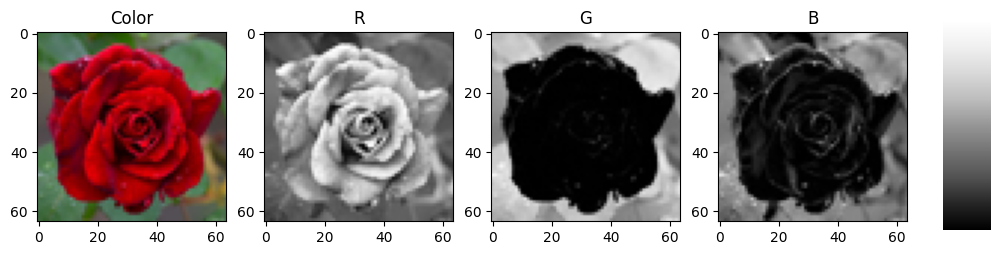

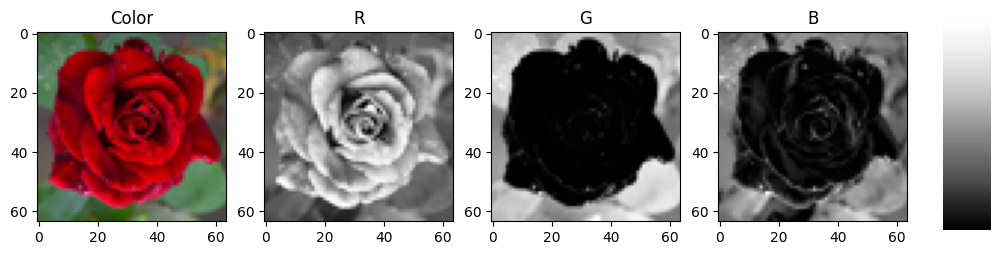

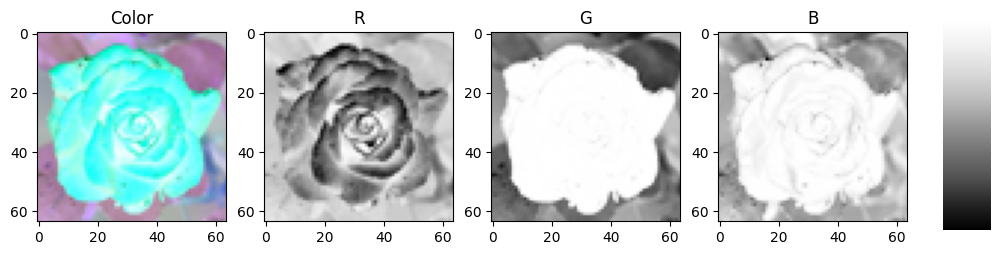

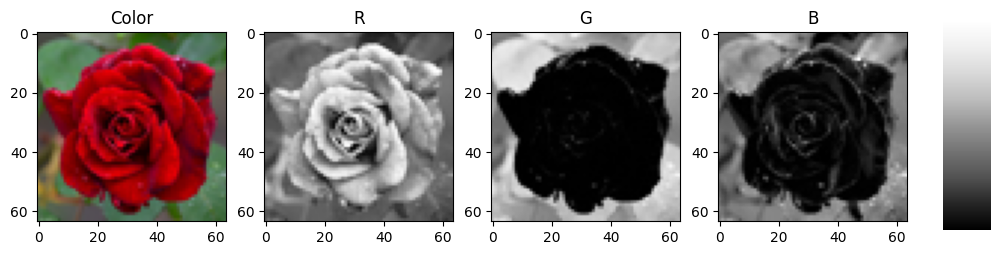

In [16]:
number = 2442
image_variants = (len(transform_techs) + 1)
mapped_number = number * image_variants
print(MAP_CHARACTERS[y[mapped_number]]) # Acceso al diccionario
layers_title = ["Gray"] if on_gray_scale else ['Color', 'R', 'G', 'B']

for i in range(image_variants):
  visualize_image_layers(X[mapped_number+i], show_layers=True, layers_title=layers_title)

## Entrenamiento

### Preparación

Normalizamos 'X' entre 0 y 1 y convertimos la clase 'y' a valores categóricos

In [17]:
# Preprocessing normalización de las imágenes
X_train = X / 255.0

In [18]:
# convert class vectors to binary class matrices
print(y)
y_train=keras.utils.to_categorical(y,len(MAP_CHARACTERS))
y_train

[0 0 0 ... 4 4 4]


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

Definimos parámetros e hiperparámetros

In [19]:
# Hiperparámetros de la red
batch_size=128
epochs = 20
img_rows,img_cols=IMG_SIZE,IMG_SIZE
num_channels = 1 if on_gray_scale else 3
input_shape = (img_rows, img_cols, num_channels) #(542, 64,64) >- GRIS; #(542, 64,64,3) >- RGB;
validation_split = 0.2

### Modelo

Definimos el modelo

In [42]:
model = keras.Sequential([
  keras.layers.Conv2D(64, kernel_size=(3, 3), data_format="channels_last", input_shape=input_shape, activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(64, activation='sigmoid'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(32, activation='sigmoid'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(5, activation='softmax')
  ])

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 31, 31, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 6, 6, 128)       

Entrenamos el modelo

In [43]:
history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = validation_split)

Epoch 1/20
69/69 [==============================] - 199s 3s/step - loss: 1.4464 - accuracy: 0.2740 - val_loss: 4.0996 - val_accuracy: 0.0000e+00
Epoch 2/20
69/69 [==============================] - 188s 3s/step - loss: 1.3680 - accuracy: 0.3095 - val_loss: 4.4197 - val_accuracy: 0.0564
Epoch 3/20
69/69 [==============================] - 179s 3s/step - loss: 1.2774 - accuracy: 0.3741 - val_loss: 4.6810 - val_accuracy: 0.0492
Epoch 4/20
69/69 [==============================] - 188s 3s/step - loss: 1.0794 - accuracy: 0.5686 - val_loss: 4.9664 - val_accuracy: 0.0660
Epoch 5/20
69/69 [==============================] - 192s 3s/step - loss: 0.8987 - accuracy: 0.6775 - val_loss: 5.4833 - val_accuracy: 0.0778
Epoch 6/20
69/69 [==============================] - 188s 3s/step - loss: 0.8185 - accuracy: 0.7118 - val_loss: 5.6989 - val_accuracy: 0.0806
Epoch 7/20
69/69 [==============================] - 184s 3s/step - loss: 0.7485 - accuracy: 0.7416 - val_loss: 5.8772 - val_accuracy: 0.0728
Epoch 8/2

### Resultados

Funciones con las gráficas de resultados de varios modelos

In [44]:
# Compara accuracys de varios entrenamientos o modelos
def plot_compare_accs(histories, ax, names, title, color=["blue", "orange", "green", "red", "black"]):
  for idx, history in enumerate(histories):
    ax.plot(histories[idx].history['accuracy'], color=color[idx])
    ax.plot(histories[idx].history['val_accuracy'], '--', color=color[idx])
  ax.set_title(title)
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch')
  ax.legend(np.concatenate([('Train ' + names[idx], 'Val ' + names[idx]) for idx, history in enumerate(histories)]), loc='upper left')

# Compara losses de varios entrenamientos o modelos
def plot_compare_losses(histories, ax, names, title, color=["blue", "orange", "green", "red", "black"]):
  for idx, history in enumerate(histories):
    ax.plot(histories[idx].history['loss'], color=color[idx])
    ax.plot(histories[idx].history['val_loss'], '--', color=color[idx])
  ax.set_title(title)
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch')
  ax.legend(np.concatenate([('Train ' + names[idx], 'Val ' + names[idx]) for idx, history in enumerate(histories)]), loc='lower left')

# Imprime gráficas con el accuracy y el loss
def plot_compare_scores(histories, names):
  fig,ax = plt.subplots(ncols=2, figsize=(10,5))
  plot_compare_accs(histories, ax[0], names, title="Model Accuracy")
  plot_compare_losses(histories, ax[1], names, title="Model Loss")

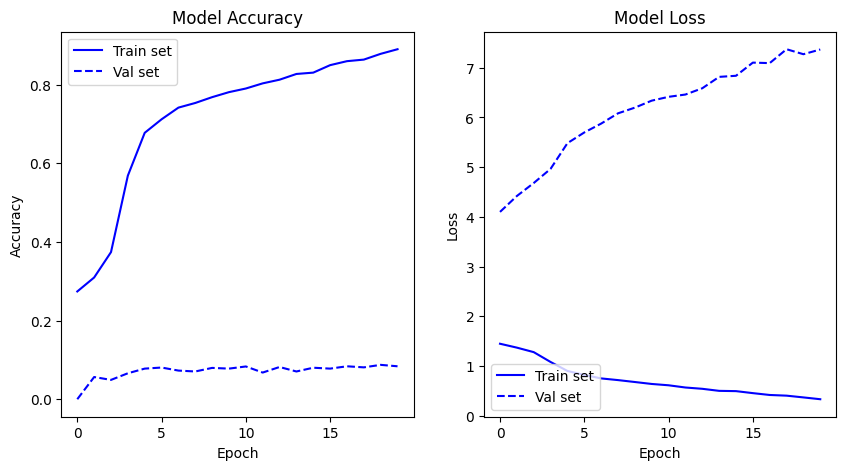

In [45]:
plot_compare_scores([history], names=['set'])

Se ha añadido un ejemplo de los resultados obtenidos usando reguladores L2 e inicialización Glorot-normal para el kernel y he-normal para los Bias. Sin embargo, este modelo no ha sido imposible exportarlo a la aplicación web, por lo que ha usado el modelo anterior peso a no conseguir un buen aprendizaje durante el entrenamiento.

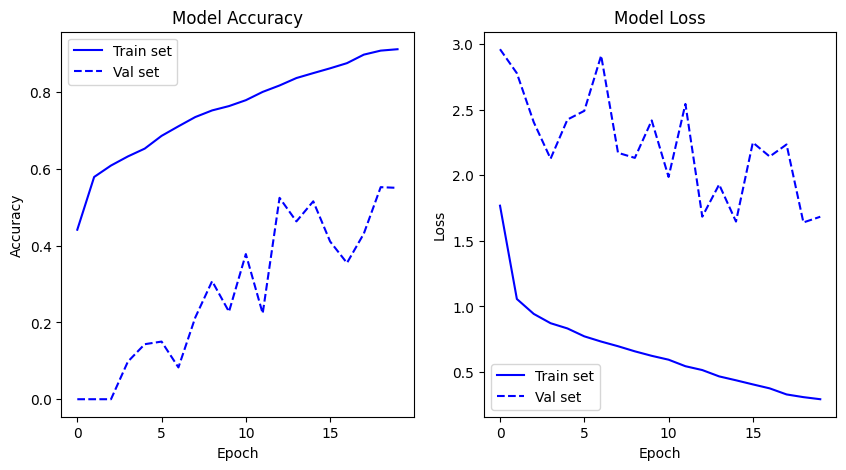

In [ ]:
plot_compare_scores([history], names=['set'])

## Predicción

### Preparación del dataset de test

En primer lugar se descarga el fichero zip y se extrae en la ruta indicada.

In [ ]:
# Rutas
zip_path = '/content/train.rar'
extraction_path = '/content/'

# Bajamos los datos del Github
keras.utils.get_file(fname=zip_path,
                     origin="https://github.com/AyozeGS/IABD/raw/main/7RO/T11_2/data/train.rar")

patoolib.extract_archive(zip_path, outdir=extraction_path, verbosity=-1)

print(f'Archivos extraídos en {extraction_path}')

164259766/164259766 [==============================] - 1s 0us/step
Archivos extraídos en /content/


In [79]:
!rm test/ -rf

In [80]:
zip_path = '/content/test.rar'
extraction_path = '/content/test'
data_path = '/content/'

In [81]:
# Rutas
zip_path = '/content/test.rar'
extraction_path = '/content/'
data_path = '/content/test'

# Bajamos los datos del Github
keras.utils.get_file(fname=zip_path,
                     origin="https://github.com/AyozeGS/IABD/raw/main/7RO/T11_2/data/test.rar")

patoolib.extract_archive(zip_path, outdir=extraction_path, verbosity=-1)

print(f'Archivos extraídos en {extraction_path}')

49409809/49409809 [==============================] - 0s 0us/step
Archivos extraídos en /content/


Se comprueban la cantidad de imágenes que tenemos

In [82]:
# Carga todos los CSV en la carpeta en un diccionario de listas de DataFrames
for root, dirs, files in os.walk(data_path):
  if len(files):
        dir = root.split('/')[-1]
        count = 0
        count2 = 0
        for file in files:
          if file.lower().endswith(('.jpg')):
            count += 1
        print(dir, '->', count, 'imágenes')

test -> 924 imágenes


Creamos el dataset de test y los normalizamos

In [83]:
X_test = []
for image_name in os.listdir(data_path):
    filename = os.path.join(data_path, image_name)
    image = get_image(filename, height=IMG_SIZE, width=IMG_SIZE, on_gray_scale=on_gray_scale)
    X_test.append(np.array(image))
X_test = np.array(X_test)
X_test_n = X_test/255

### Predicción

In [84]:
y_pred=model.predict(X_test_n, batch_size=32, verbose=1)  # Almacenamos todas las predicciones para los datos de test
y_pred = np.array([np.argmax(y_sample) for y_sample in y_pred])

29/29 [==============================] - 4s 130ms/step


Se muestra imagenes de prueba y su predicción

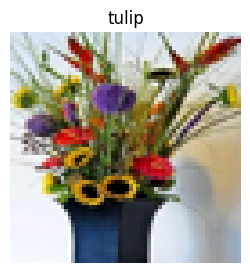

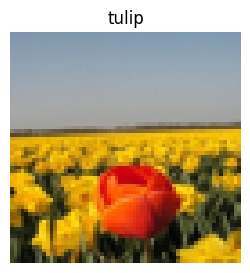

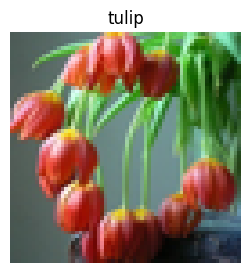

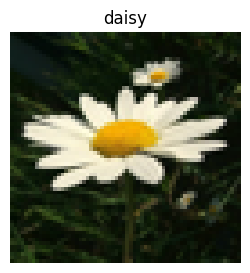

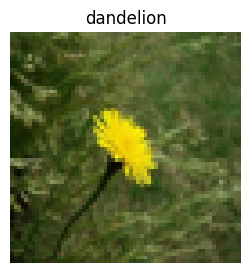

In [85]:
for sample in range(5):
  i = np.random.randint(len(y_pred)+1)
  visualize_image_layers(X_test[i], show_layers=False, layers_title=[MAP_CHARACTERS[y_pred[i]]])

## Exportación del modelo

In [86]:
#Exportar el modelo en formato h5 (LEGACY)
model.save('flowers.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [88]:
#El equipo es Linux. Listemos el contenido de la carpeta actual para ver que se exporto el modelo
!ls

flowers.h5  flowers.keras  sample_data	test  test.rar	train  train.rar


In [89]:
#Para convertirlo a tensorflow.js, primero debemos instalar la libreria
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
     

In [1]:
#Crear carpeta donde se colocaran los archivos resultantes
!mkdir carpeta_salida

mkdir: cannot create directory ‘carpeta_salida’: File exists


In [2]:
#Realizar la exportacion a la carpeta de salida
!tensorflowjs_converter --input_format keras flowers.h5 carpeta_salida

2024-05-13 00:34:17.051534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 00:34:22.218959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Interfaz

Una vez exportado el modelo agregamos a la parte de front-end los ficheros '.json' y '.bin' creados, Se ejecutará una pequeña interfaz web que importará el modelo.

Para visualizarlo crearemos un pequeño servidor http usando python en el directorio donde se encuentra dicho proyecto web, con el comando:

python -m http.server 8000

Una vez hecho, basta con usar el navegador hacia el puerto definido de nuestra máquina local. En este ejemplo, "localhost:8000".

Para la cámara, conectaremos el ordenador al móvil a través de la aplicación DroidCam.

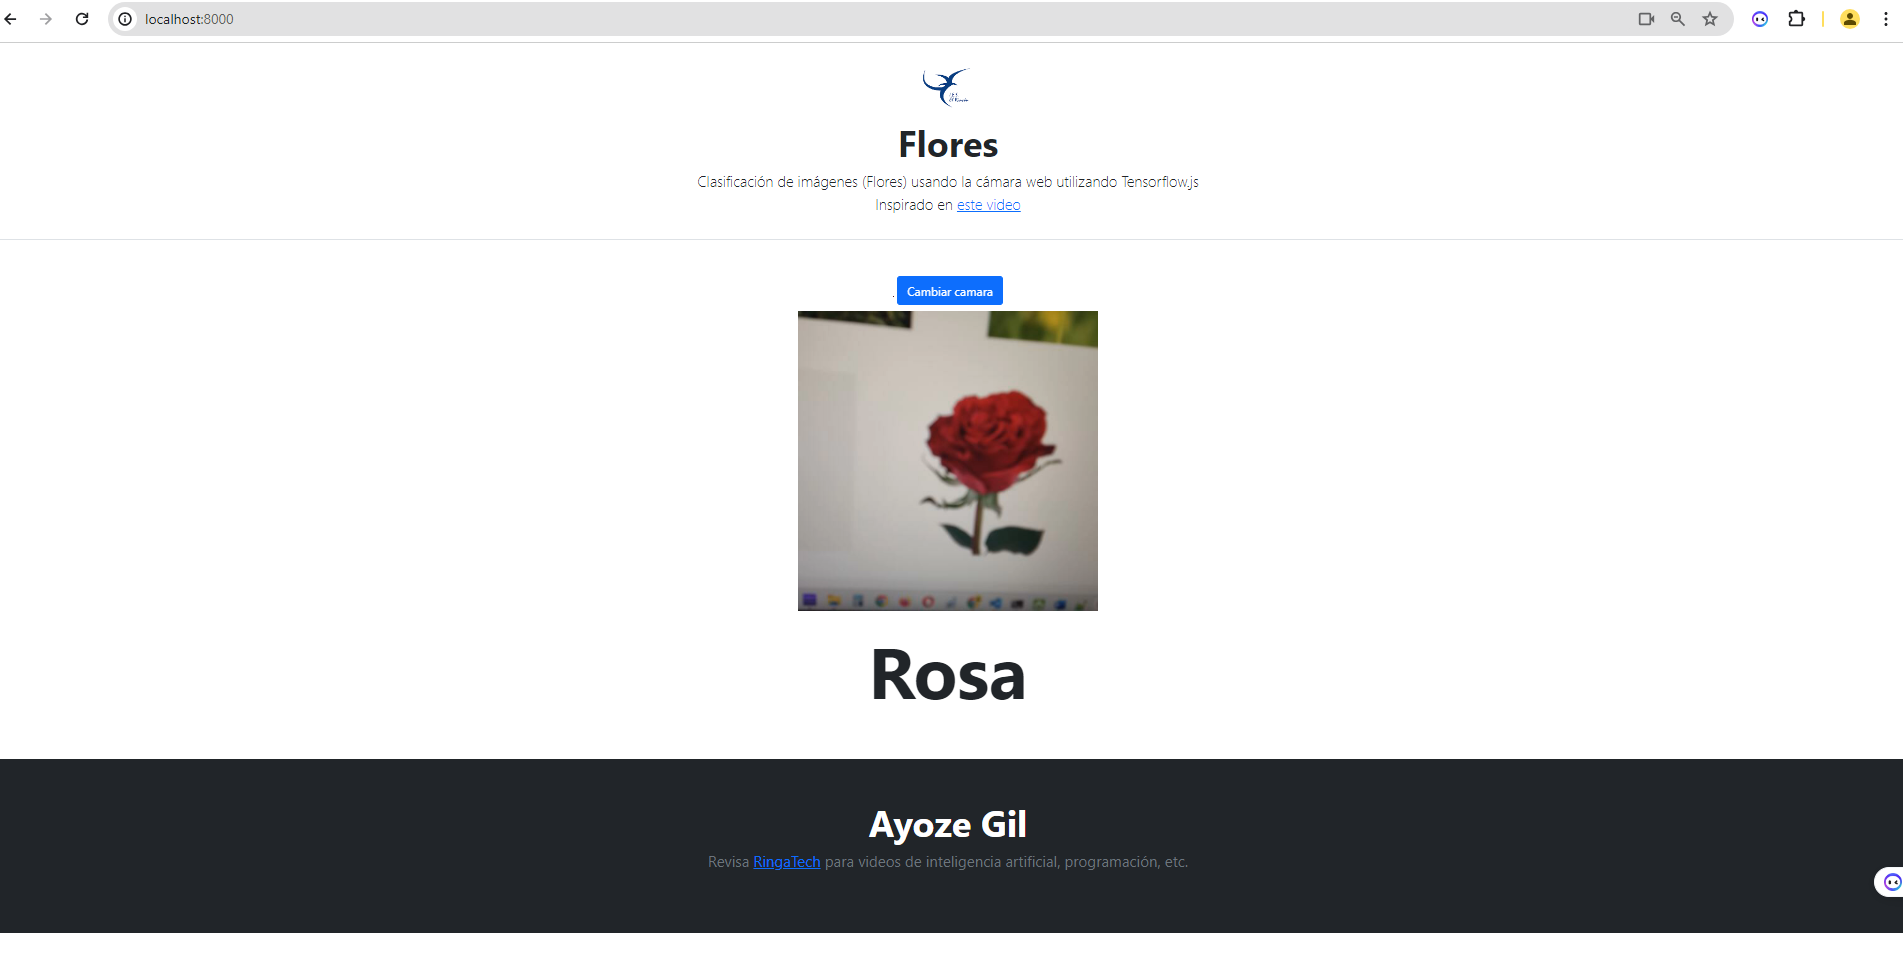

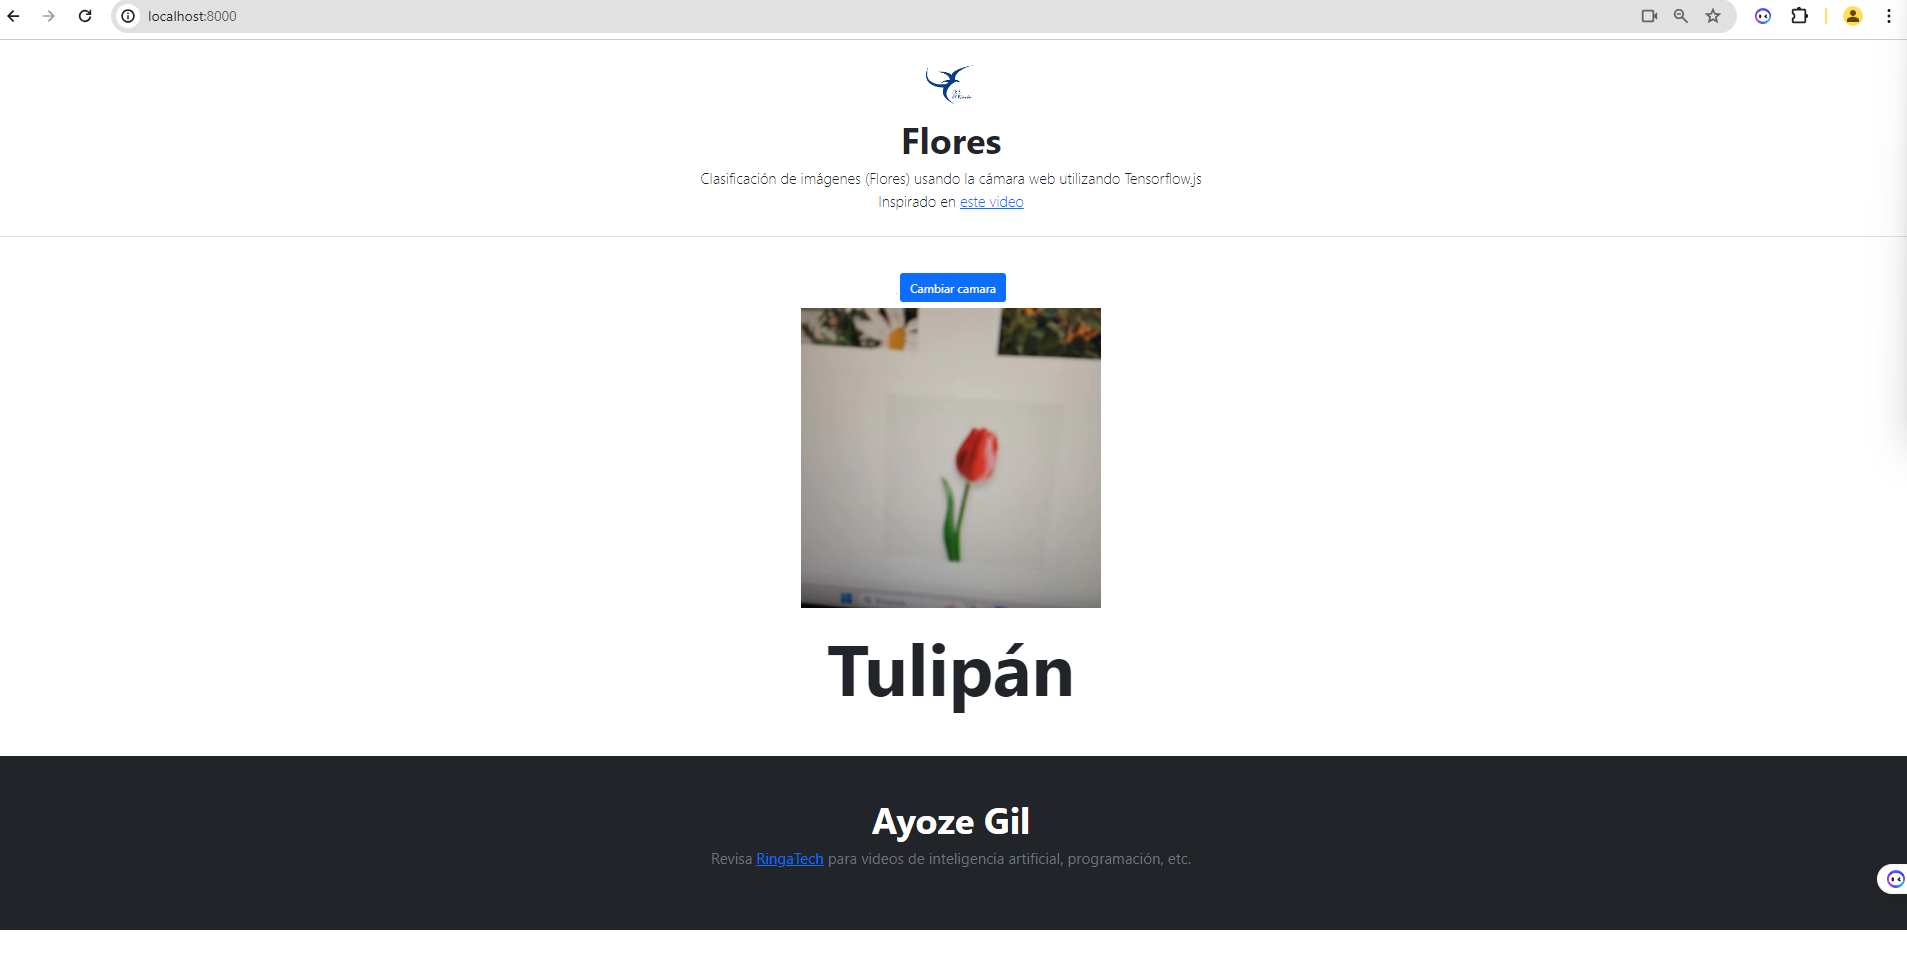